# PN2V Prediction
Please run the `04_ProbabilisticNoise2VoidTraining.ipynb` notebook first.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread
import sys
sys.path.append('../../')
from unet.model import UNet
from pn2v.utils import denormalize
from pn2v.utils import normalize
from pn2v.utils import PSNR
from pn2v import utils
from pn2v import prediction
import pn2v.training
from pn2v import histNoiseModel
from pn2v import gaussianMixtureNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='../../data/Convallaria_diaphragm/'

# Load the test data
dataTest=imread(path+"20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif")[:,:512,:512] 
# We are loading only a sub image to spped up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]



### Load the Network and Noise Model

In [3]:
typeNoiseModel='GMM' # Choose 'GMM' or 'histogram' to specify the appropriate noise model
dataName = 'convallaria'# Use the same name as used in ProbabilisticNoise2VoidTraining.ipynb. This is a part of model name created in ProbabilisticNoise2VoidTraining.ipynb
mode = 'bootstrap' #  #Either 'bootstrap'(bootstrapping mode) or 'calibration'(using calibration data)
if (typeNoiseModel =='GMM'):
    n_gaussian = 3 # If using GMM noise model, specify number of Gaussians created in CreateNoiseModel_GMM.ipynb
    n_coeff = 2 # If using GMM noise model, specify number of coefficients created in CreateNoiseModel_GMM.ipynb

In [4]:
if(typeNoiseModel=='GMM'): 
    namePN2VModel=dataName+'_GMM_'+str(n_gaussian)+'gaussian_'+str(n_coeff)+'coefficients_'+mode
    params= np.load(path+'trained_weights_minSignal_maxSignal_GMM_'+dataName+'_'+str(n_gaussian)+'gaussian_'+str(n_coeff)+'coefficients_'+mode+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params['min_signal'][0], params['max_signal'][0],
                                                                     torch.Tensor(params['trained_weight']))
else:
    namePN2VModel=dataName+'_histogram_'+mode
    histogram = np.load(path+'noiseModelHistogram_'+ dataName+'_'+mode+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)

/home/lalit/Desktop/01_Softwares/anaconda3/envs/ppn2vEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU1 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [5]:
net=torch.load(path+"/last_"+namePN2VModel+".net")

### Evaluation

image: 0
PSNR input 29.009240856174337
PSNR prior 35.8114267821602
PSNR mse 36.52587651783565
-----------------------------------
image: 1
PSNR input 29.018589127299936
PSNR prior 35.77088117935101
PSNR mse 36.470182063618374
-----------------------------------
image: 2
PSNR input 29.035458856560645
PSNR prior 35.809360508965085
PSNR mse 36.51729790481114
-----------------------------------
image: 3
PSNR input 28.990347509982925
PSNR prior 35.854301033275036
PSNR mse 36.58097823213844
-----------------------------------
image: 4
PSNR input 29.002852113680238
PSNR prior 35.846554529603985
PSNR mse 36.56439790211251
-----------------------------------
image: 5
PSNR input 29.02402327393454
PSNR prior 35.840744129517326
PSNR mse 36.536729803530235
-----------------------------------
image: 6
PSNR input 29.032053580418268
PSNR prior 35.85737427005895
PSNR mse 36.56683796211195
-----------------------------------
image: 7
PSNR input 29.017435705343363
PSNR prior 35.820870000691365
PSNR mse 3

image: 63
PSNR input 28.943605925782467
PSNR prior 35.85468238205892
PSNR mse 36.576704475716866
-----------------------------------
image: 64
PSNR input 28.984797176949073
PSNR prior 35.829094829665905
PSNR mse 36.537880158137355
-----------------------------------
image: 65
PSNR input 28.994764258029022
PSNR prior 35.90845019919206
PSNR mse 36.64526074936853
-----------------------------------
image: 66
PSNR input 28.974272339535343
PSNR prior 35.867094772030434
PSNR mse 36.5827844553528
-----------------------------------
image: 67
PSNR input 28.968391660007423
PSNR prior 35.91490846181177
PSNR mse 36.6412976631728
-----------------------------------
image: 68
PSNR input 28.930129735581886
PSNR prior 35.80112232304099
PSNR mse 36.53338108261118
-----------------------------------
image: 69
PSNR input 28.97258922282324
PSNR prior 35.91163386782374
PSNR mse 36.653771013892054
-----------------------------------
image: 70
PSNR input 28.917087395242863
PSNR prior 35.80605433984432
PSNR 

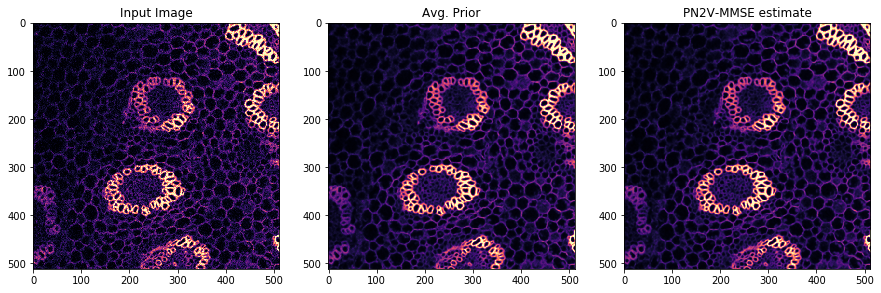

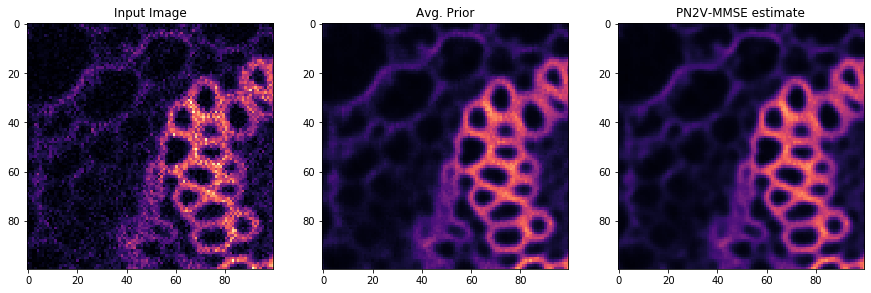

Avg PSNR Prior: 35.85300505785988 +-(2SEM) 0.008061247244731963
Avg PSNR MMSE: 36.573605949727 +-(2SEM) 0.009310382645850311


In [6]:
# Now we are processing data and calculating PSNR values.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    means, mseEst = prediction.tiledPredict(im, net, ps=128, overlap=48,
                                             device=device, noiseModel=noiseModel)

    
    resultImgs.append(mseEst)
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    psnr=PSNR(gt, mseEst,rangePSNR )
    psnrPrior=PSNR(gt, means,rangePSNR )
    results.append(psnr)
    meanRes.append(psnrPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR prior",psnrPrior) # Without info from masked pixel
    print ("PSNR mse",psnr) # MMSE estimate using the masked pixel
    print ('-----------------------------------')

    
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst, vmax=vma, vmin=vmi, cmap='magma')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
plt.show()

print("Avg PSNR Prior:", np.mean(np.array(meanRes) ), '+-(2SEM)',2*np.std(np.array(meanRes) )/np.sqrt(float(len(meanRes)) ) )
print("Avg PSNR MMSE:", np.mean(np.array(results) ),  '+-(2SEM)' ,2*np.std(np.array(results) )/np.sqrt(float(len(results)) ) )